# Домашнее задание №2

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
device = torch.device('cuda:0')

In [3]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [4]:
transform_all = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

In [5]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████| 1254/1254 [00:00<00:00, 1645.17it/s]


In [6]:
dataset[0][1].shape

torch.Size([3, 128, 128])

In [7]:
def StepForward(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.MaxPool2d((2, 2), stride=(2, 2)),
        nn.ReLU()
    )

def StepBackward(channels_in, channels_out):
    return nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.ReLU()
    )

In [8]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            StepForward(1, 64),
            StepForward(64, 128),
            StepForward(128, 256),
            StepForward(256, 512),
            
            StepBackward(512, 256),
            StepBackward(256, 128),
            StepBackward(128, 64),
            nn.Upsample(scale_factor=2)
        )
         
        self.postconcat = nn.Sequential(
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [9]:
model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

100%|████████████████████████████████████████████████████████████████████████████| 4500/4500 [3:09:24<00:00,  2.53s/it]


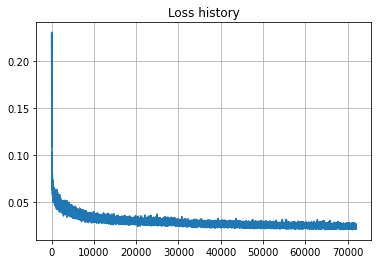

In [10]:
history = []

for epoch in tqdm(range(4500)):
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        colorized = model(x)
        
        loss = criterion(colorized, y)
        
        history.append(loss.item())
        
        loss.backward()
        
        optimizer.step()

plt.plot(history)
plt.title('Loss history')
plt.grid()
plt.show()

In [11]:
def to_numpy_image(img):
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

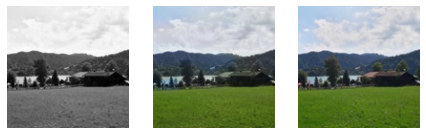

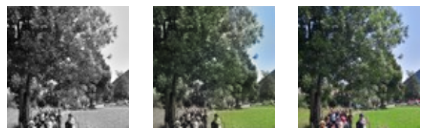

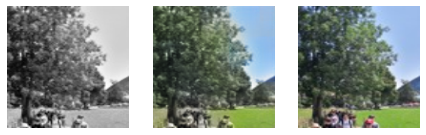

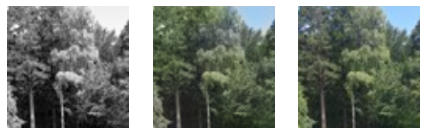

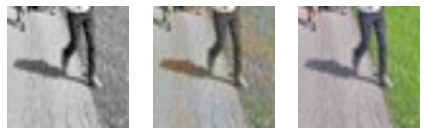

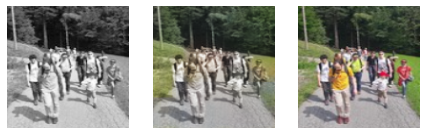

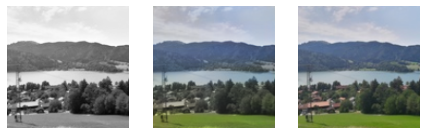

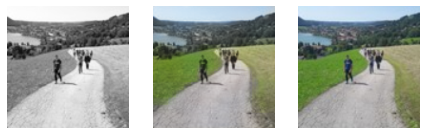

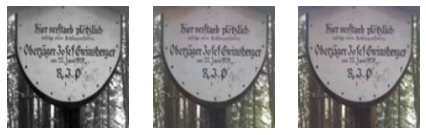

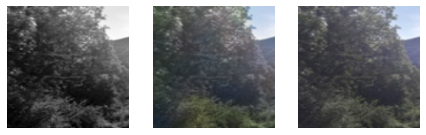

In [12]:
for t in range(10):
    img_gray, img_true = dataset[t]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()